In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"Shape of DBTL cycle 1: {df_A.shape} and DBTL cycle 2: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds


bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of DBTL cycle 1: (27, 10) and DBTL cycle 2: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


# Model selection (NCV)

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

# ## Uncomment to run model selection
# modelSelection(X_train, y_train)

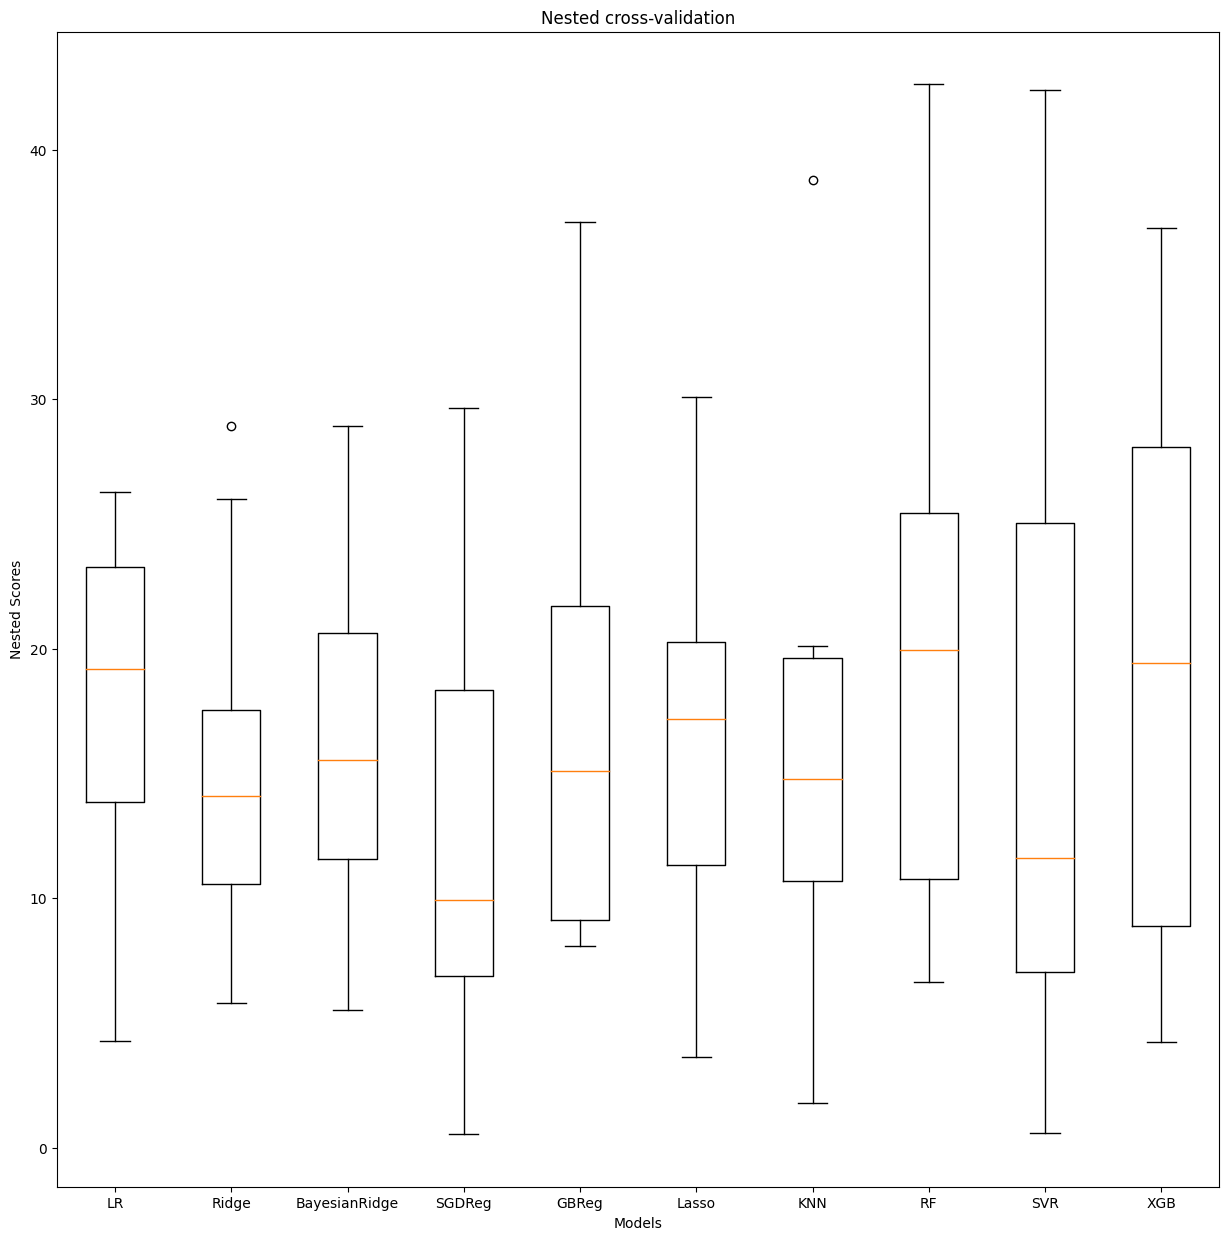

# ML training (Optuna)

In [ ]:
# import optuna
# from sklearn.svm import SVR
# from sklearn.model_selection import cross_val_score


# def objective(trial):
#     # Define the hyperparameters to optimize
#     C = trial.suggest_loguniform("C", 0.01, 100)
#     epsilon = trial.suggest_loguniform("epsilon", 0.01, 1)
#     gamma = trial.suggest_loguniform("gamma", 0.001, 1)
#     kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
#     degree = trial.suggest_int("degree", 2, 5)

#     # Create the SVR model with the hyperparameters
#     model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel, degree=degree)
#     scores = cross_val_score(
#         model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
#     )
#     return -scores.mean()


# # Create the study object and optimize the objective function
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
# best_params = study.best_params
# final_model = SVR(**best_params)
# final_model.fit(X_train, y_train)

In [3]:
import optuna
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-5, 1e-1)
    l1_ratio = trial.suggest_uniform("l1_ratio", 0, 1)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "optimal", "invscaling"])
    eta0 = trial.suggest_loguniform("eta0", 1e-5, 1e-1)
    model = SGDRegressor(alpha=alpha, l1_ratio=l1_ratio, learning_rate=learning_rate, eta0=eta0)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    return -scores.mean()

# Create the study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
final_model = SGDRegressor(**best_params)
final_model.fit(X_train, y_train)


[I 2024-02-16 15:39:03,036] A new study created in memory with name: no-name-1824bef5-e5b7-4c59-97e9-3aacf37b2c41
[I 2024-02-16 15:39:03,105] Trial 0 finished with value: 15.568597174664978 and parameters: {'alpha': 0.0036510451111108062, 'l1_ratio': 0.5128668195043001, 'learning_rate': 'constant', 'eta0': 1.0524723548468725e-05}. Best is trial 0 with value: 15.568597174664978.
[I 2024-02-16 15:39:03,168] Trial 1 finished with value: 15.468054731839374 and parameters: {'alpha': 0.014659130129977741, 'l1_ratio': 0.3593333688034046, 'learning_rate': 'constant', 'eta0': 2.1676885652208408e-05}. Best is trial 1 with value: 15.468054731839374.
[I 2024-02-16 15:39:03,222] Trial 2 finished with value: 136632125444751.5 and parameters: {'alpha': 0.000245286396024042, 'l1_ratio': 0.8845929315640718, 'learning_rate': 'optimal', 'eta0': 0.023107366053206266}. Best is trial 1 with value: 15.468054731839374.
[I 2024-02-16 15:39:03,266] Trial 3 finished with value: 22.21587865857814 and parameters: 

SGDRegressor(alpha=0.048625125047512555, eta0=1.435759750540562e-05,
             l1_ratio=0.22995764236103897, learning_rate='constant')

# Model evaluation (Bootstrap)

In [5]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values


mae_values = bootstrap(X_train, y_train, SGDRegressor(**final_model.get_params()))
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 94.99it/s]

Bootstraped Mean(MAE) = 16.52172345824804


SGDRegressor(alpha=0.048625125047512555, eta0=1.435759750540562e-05,
             l1_ratio=0.22995764236103897, learning_rate='constant')

# Explainable AI 

  0%|          | 0/27 [00:00<?, ?it/s]

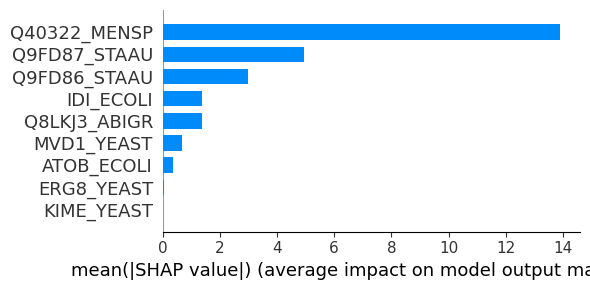

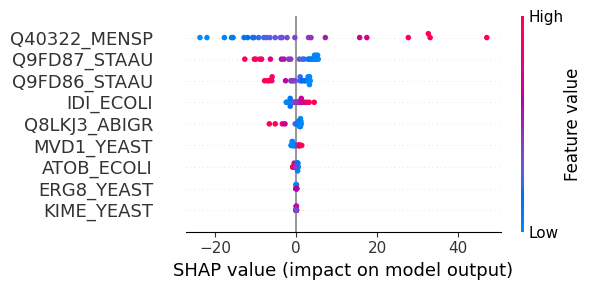

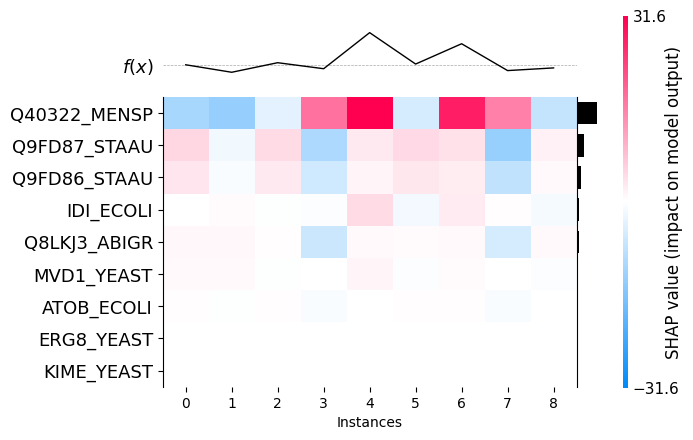

In [6]:
import shap
import matplotlib.pyplot as plt


def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.KernelExplainer(final_model.predict, df_A[INPUT_VARS])
shap_values = shap_explainer(df_A[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = final_model.predict(df_A[INPUT_VARS])
shap_df["true"] = df_A[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

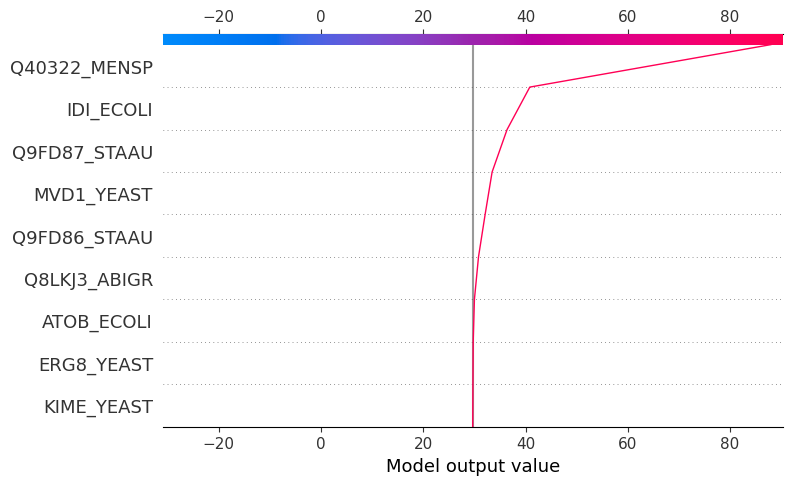

pred    87.967691
true    75.392610
Name: 0, dtype: float64


In [7]:
idx=0
shap.decision_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[idx].values, 
                   INPUT_VARS)

print(shap_df[['pred', 'true']].iloc[idx])

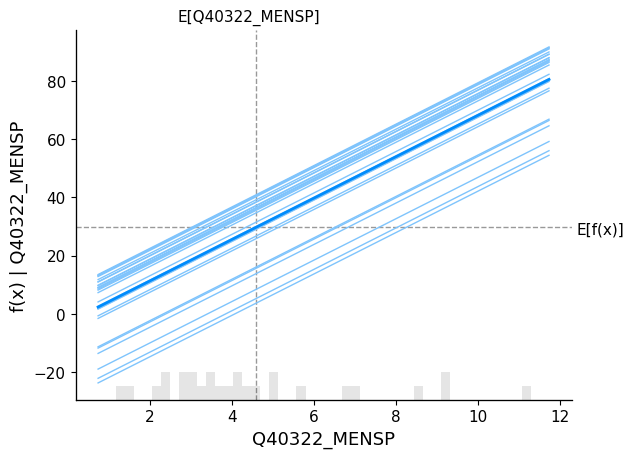

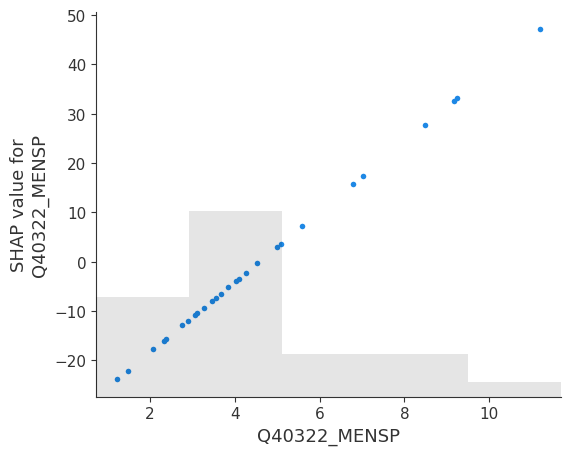

In [8]:
feature = "Q40322_MENSP"
pdplot(df_A[INPUT_VARS], feature, final_model, ice=True)
shap_scatter(feature)

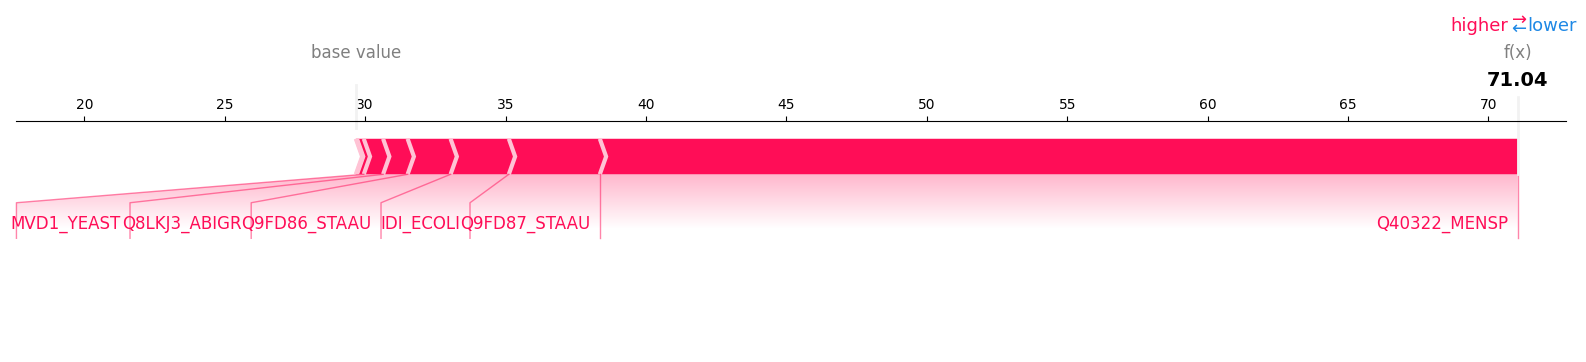

In [9]:
shap.force_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[2].values, 
                   features=INPUT_VARS,
                   matplotlib=True, show=True)

# Lime

In [10]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Limonene"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Limonene", ascending=False, inplace=True)
# Drop rows with Limonene < 0
sample_df = sample_df[sample_df["Limonene"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Limonene"]

Intercept 24.4726719012029
Prediction_local [79.19320402]
Right: 88.16612452446171


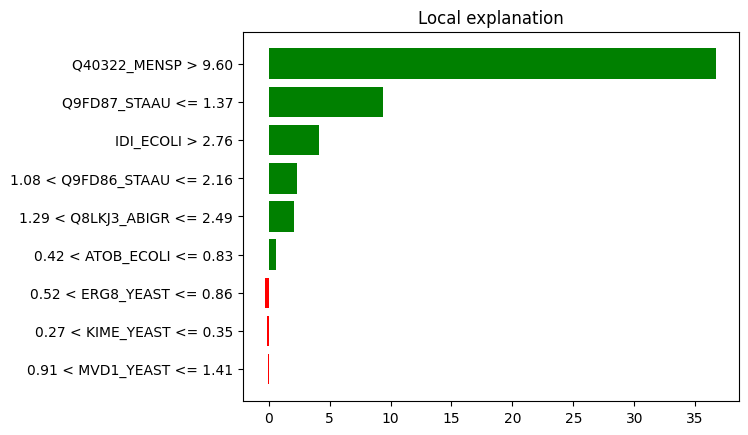

In [31]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_synth.values, feature_names=INPUT_VARS,  
                                                   verbose=True, mode='regression')
                                                   
i = 0
exp = explainer.explain_instance(X_synth.values[i], final_model.predict)
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_list()
exp.as_pyplot_figure();

# Sampling

Create new `sampling bounds`, to generate/recommend new strain designs.

In [14]:
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


In [15]:
df_B 

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494
BL.Ml,0.24012,0.19050,0.94884,0.38070,1.30811,2.72406,0.11237,0.05002,0.08503,6.72018


In [32]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 9.60
sampling_bounds["Q40322_MENSP"].loc["max"] = bounds["Q40322_MENSP"].loc["max"]

sampling_bounds["ATOB_ECOLI"].loc["min"] = bounds["ATOB_ECOLI"].loc["min"]
sampling_bounds["ATOB_ECOLI"].loc["max"] = bounds["ATOB_ECOLI"].loc["max"]

sampling_bounds["Q9FD87_STAAU"].loc["min"] = bounds["Q9FD87_STAAU"].loc["min"]
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 1.37

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = 1.29 #bounds["Q8LKJ3_ABIGR"].loc["min"]
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 2.49

sampling_bounds["Q9FD86_STAAU"].loc["min"] = 1.08 # bounds["Q9FD86_STAAU"].loc["min"]
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 2.16

sampling_bounds["MVD1_YEAST"].loc["min"] = bounds["MVD1_YEAST"].loc["min"]
sampling_bounds["MVD1_YEAST"].loc["max"] = bounds["MVD1_YEAST"].loc["max"]

sampling_bounds["ERG8_YEAST"].loc["min"] = 0.52
sampling_bounds["ERG8_YEAST"].loc["max"] = 0.86 # bounds["ERG8_YEAST"].loc["max"]

sampling_bounds["KIME_YEAST"].loc["min"] = bounds["KIME_YEAST"].loc["min"]
sampling_bounds["KIME_YEAST"].loc["max"] = bounds["KIME_YEAST"].loc["max"]

sampling_bounds["IDI_ECOLI"].loc["min"] = 2.76
sampling_bounds["IDI_ECOLI"].loc["max"] = bounds["IDI_ECOLI"].loc["max"]

# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
3799,0.506766,0.636660,3.193283,0.324084,1.815182,12.138195,1.372386,1.118637,0.056504,93.386081
28,0.388792,0.796862,3.112893,0.264646,2.114207,12.149628,1.301649,1.164419,0.252890,93.100902
3760,0.175457,0.576533,3.225155,0.314637,1.832793,12.196331,1.674879,1.301086,0.104400,92.972343
6159,0.206289,0.748643,3.415093,0.261560,2.111719,12.015262,1.950796,1.123440,0.112219,92.616194
6847,0.835736,0.606061,3.378882,0.161011,1.828909,12.165396,1.553646,1.163140,0.316757,92.403515
5179,0.498431,0.604680,3.403166,0.222772,2.054330,12.165891,1.710024,1.270357,0.447894,92.081531
1321,0.699720,0.726028,3.293037,0.397982,2.083749,12.145730,1.337959,1.358174,0.429698,92.034399
9472,0.450531,0.638749,3.209434,0.242563,2.049155,12.079236,1.546672,1.478413,0.066413,92.023566
9761,0.700509,0.825123,3.139531,0.140203,2.214106,11.950161,1.405237,1.201791,0.077291,91.938625
5561,0.509700,0.816579,3.366550,0.361213,2.293801,12.159346,2.063624,1.308616,0.360682,91.937447


# Counterfactuals (`DiCE`)

In [33]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:3]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn",model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=10,
    desired_range=[70, 75],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
# e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


In [36]:
cf_df = pd.DataFrame()
for i in range(len(e1.cf_examples_list)):
    _ = e1.cf_examples_list[i].final_cfs_df
    # Concatenate the dataframes
    cf_df = pd.concat([cf_df, _], axis=0)

cf_df.sort_values('Limonene', ascending=False, inplace=True)
cf_df.head(3)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.1351,0.5200,2.76,0.2536,0.4557,10.0497,1.6200,1.2888,0.0429,74.679962
0,0.0219,0.7048,2.76,0.3938,1.7532,9.6000,1.3799,1.0800,0.0429,74.625362
0,0.0219,0.5572,2.76,0.2661,1.6878,9.6023,1.4227,1.0800,0.0429,74.407507


# PCA

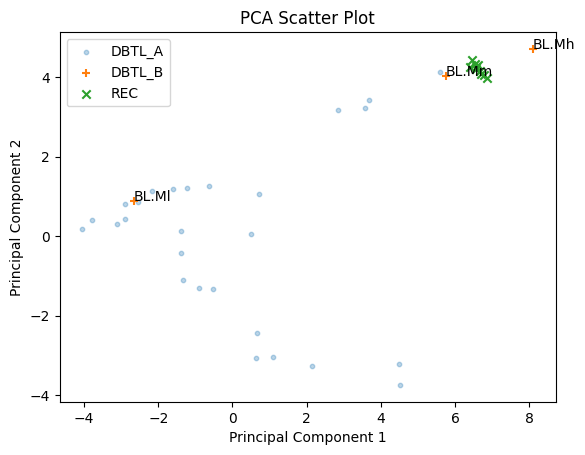

BL.Mh    127.99494
BL.Mm    119.81367
BL.Ml      6.72018
Name: Limonene, dtype: float64


In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(sample_df[INPUT_VARS][:10])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker="+")
for i, txt in enumerate(DBTL_B):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker="x")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(df_B["Limonene"].sort_values(ascending=False))

In [ ]:
df_A.sort_values("Limonene", ascending=False, inplace=True)
df_A.head(3)

In [ ]:
final_model.predict(df_B[INPUT_VARS])

In [ ]:
from scipy.spatial import distance

# Assuming you have two vectors vec1 and vec2
vec1 = sample_df.iloc[0][INPUT_VARS]
vec2 = df_A.iloc[24][INPUT_VARS]


def calculate_similarity(vec1, vec2):
    # Use the euclidean function from scipy's distance module to calculate the Euclidean distance
    euclidean_distance = distance.euclidean(vec1, vec2) 
    manhattan_distance = distance.cityblock(vec1, vec2)
    cosine_distance = distance.cosine(vec1, vec2)
    pearson_corr = np.corrcoef(vec1, vec2)[0][1]
    print(f"Euclidean distance: {euclidean_distance}")
    print(f'Manhattan distance: {manhattan_distance}')
    print(f'Cosine distance: {cosine_distance}')
    print(f'Pearson correlation: {pearson_corr}')

calculate_similarity(vec1, vec2)